__TTS - Trịnh Nhật Tân - Data Science - TP. Hồ Chí Minh__

__NỘI DUNG__


*   Phân tích bài toán
*   Sử dụng LSTM cho bài toán
*   Kết quả

\
**Lưu ý:**

Để tiết kiệm thời gian cho anh/chị, ở phần test em đã cung cấp sắn link download trọng số, do đó anh/chị có thể khởi tạo mô hình và có thể không chạy lại phần training và validation cũng được ạ.


In [25]:
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset

from torchsummary import summary
from tqdm import tqdm

# Phân tích bài toán

In [3]:
ticket_list = ['FPT', 'MSN', 'PNJ', 'VIC']

for ticket in ticket_list:
    vars()[ticket] = pd.read_csv(f"./{ticket}.csv")

company_list = [FPT, MSN, PNJ, VIC]

In [4]:
for c in company_list:
    c['Date/Time'] = pd.to_datetime(c['Date/Time'])
    c['Time'] = [d.time() for d in c['Date/Time']]
    c['Date/Time'] = [d.date() for d in c['Date/Time']]
    c.rename(columns={"Date/Time": "Date"}, inplace=True)
    # c['Price_Diff'] = c.groupby(c['Date'])['Close'].diff()
    c.set_index(c.columns[1], inplace=True)

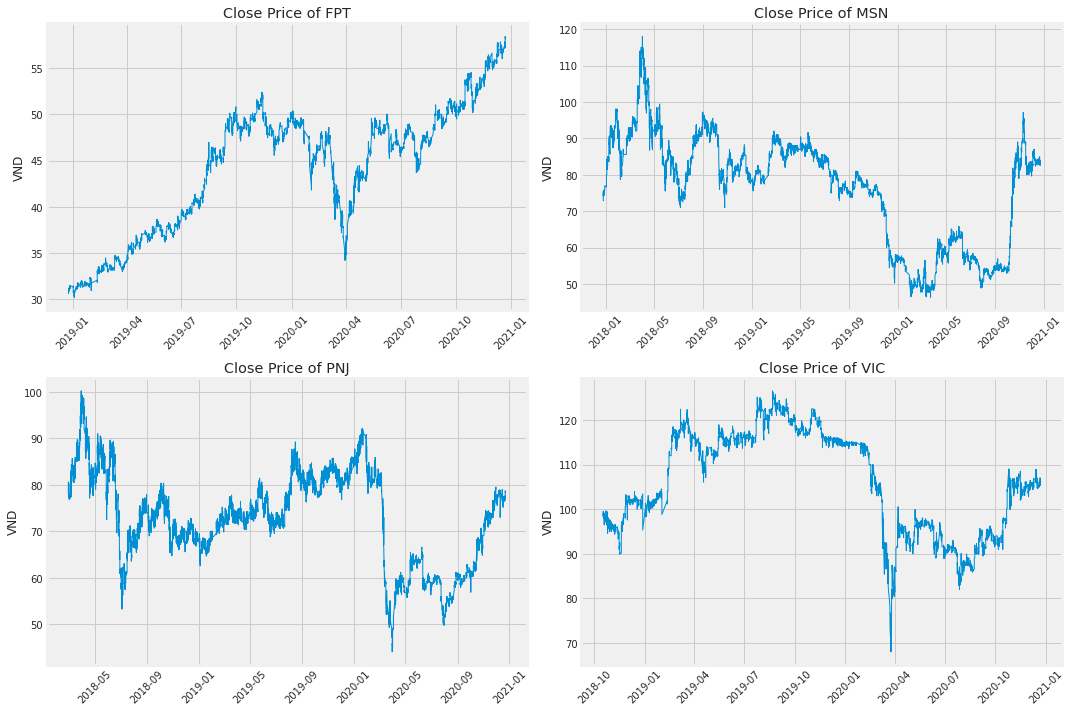

In [5]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Close'].plot(linewidth=1)
    plt.ylabel('VND')
    plt.xlabel(None)
    plt.xticks(rotation=45)
    plt.title(f"Close Price of {ticket_list[i - 1]}")
    
plt.tight_layout()
# plt.savefig("./Close_through_time.png")

Theo như yêu cầu bài toán là **dự đoán biến động giá** theo công thức được cho là 

<center><em>biến động giá  = giá cổ phiếu sau  - giá cổ phiếu hiện tại</em></center>

Để cho dữ liệu được liên tục thì em đã `groupby()` theo ngày, và `diff()` (trừ) hai dòng liên tiếp nhau, điều đó đồng nghĩa là em đã mặc định cho toàn bộ dữ liệu là hai bản ghi liên tiếp nhau thì cách nhau một phút hay vài phút. Sau đó em minh họa giá trị của cột `Price_Diff` thì được hình dưới đây:

![Price Difference through time](https://raw.githubusercontent.com/trnhattan/Finpros-Technical-Test/main/Price_Diff_through_time.png)

Với hình minh họa trên cho thấy giá biến động lên xuống khá nhiều, cụ thể là xung quanh đường $y=0$ và điều đó làm cho mô hình rất khó học. Khi em sử dụng [Moving Average](https://www.indeed.com/career-advice/career-development/simple-moving-average-forecasting) (MA), một phương pháp đơn giản để xác định xu hướng của dữ liệu trong một time frame xác định, thì kết quả cho ra rất tương đồng với mô hình `LSTM` được sử dụng trong phần dưới. 

![Price Difference trends](https://github.com/trnhattan/Finpros-Technical-Test/blob/main/Price_Diff_Trends.png?raw=true)

Kết quả dự đoán biến động giá trên mã chứng khoán FPT, mô hình được train với các tham số như sau:

*   Tỉ lệ dữ liệu $train:val = 0.8:0.2$
*   Mô hình giống như trong phần LSTM
*   `SGD(lr=0.01)`

![FPT Price Difference Prediction](https://github.com/trnhattan/Finpros-Technical-Test/blob/main/FPT_LSTM_Price_diff_prediction.png?raw=true)


Mặc dù đã đã thử rất nhiều cách để xác định vấn đề rõ hơn, như: thay đổi mô hình (thêm bớt một lớp `LSTM`, hay lớp `Linear`), `MinMaxScaler` trong nhiều range khác nhau, nhưng kết quả vẫn không đổi.

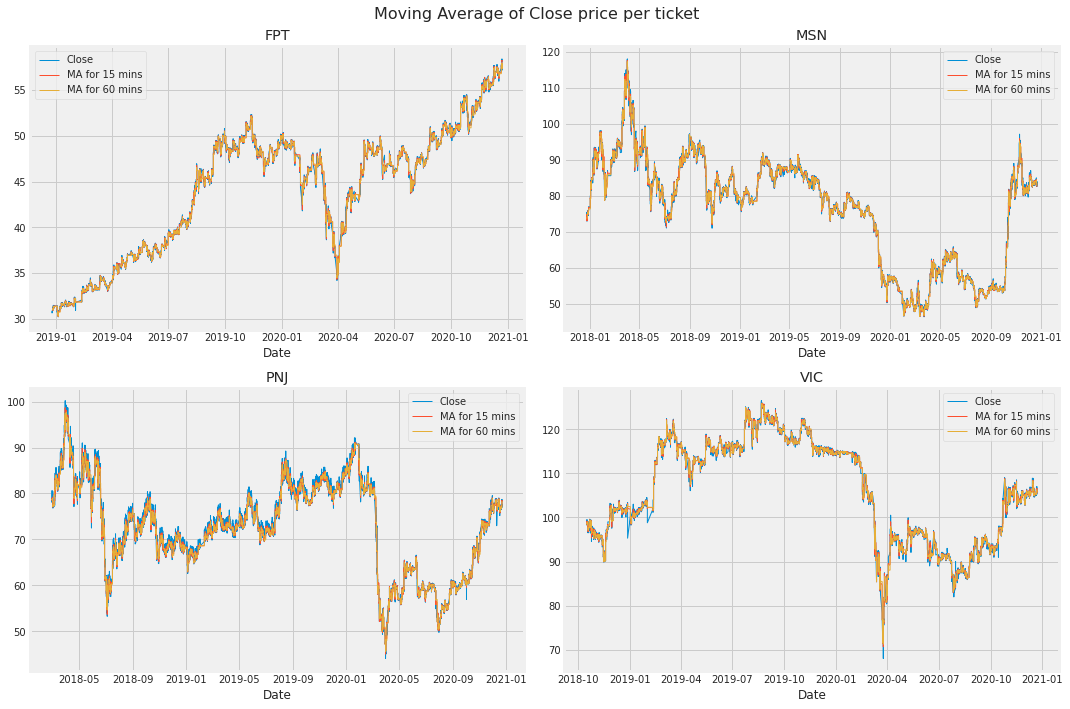

In [6]:
ma_day = [15, 60]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} mins"
        company[column_name] = company['Close'].rolling(ma).mean()
        

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle("Moving Average of Close price per ticket", fontsize=16)
fig.set_figheight(10)
fig.set_figwidth(15)

FPT[['Close', 'MA for 15 mins', 'MA for 60 mins']].plot(ax=axes[0,0], linewidth=1)
axes[0,0].set_title('FPT')

MSN[['Close', 'MA for 15 mins', 'MA for 60 mins']].plot(ax=axes[0,1], linewidth=1)
axes[0,1].set_title('MSN')

PNJ[['Close', 'MA for 15 mins', 'MA for 60 mins']].plot(ax=axes[1,0], linewidth=1)
axes[1,0].set_title('PNJ')

VIC[['Close', 'MA for 15 mins', 'MA for 60 mins']].plot(ax=axes[1,1], linewidth=1)
axes[1,1].set_title('VIC')

fig.tight_layout()

# plt.savefig("Close_Trends.png")

Tuy nhiên khi sử dụng Moving Average trên giá đóng cửa của từng mã chứng khoán thì kết quả cho ra rất ấn tượng, MA hầu như dự đoán gần như giống xu hướng của mã chứng khoán đó.
![Closs Price MA](https://github.com/trnhattan/Finpros-Technical-Test/blob/main/ClosePrice_Trends.png?raw=true)

Do đó, em đã thử và đổi hướng bài toán thành **dự đoán giá chứng khoán và từ đó tìm biến động giá**.

# LSTM

## Khởi tạo `Dataset` class và mô hình `LSTM4Stock`

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X).to(torch.float)
        self.y = torch.from_numpy(y).to(torch.float)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

In [8]:
class LSTM4Stock(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(LSTM4Stock, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, 1)

    def forward(self, x):
        y, _ = self.lstm(x)
        y = self.fc(y[:, -1, :])
        return y

In [9]:
model = LSTM4Stock(input_size=1, hidden_size=64, num_layers=2)
model.to(device)

LSTM4Stock(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Vì bài toán là bài toán hồi quy nên đơn giản loss function là *Mean Square Error* và optimizer là `SGD` có learning rate là $0.01$.

Lý do em chọn `SGD` optimizer cho bài toán này là vì dữ liệu đã cho rất đơn giản và cá nhân em đã thực nghiệm `Adam` nhưng loss performance không tốt, nên cuối cùng em đã quyết định chọn `SGD`.

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Xử lý dữ liệu

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [12]:
def split_data(in_data: np.array, seq_len: int, test_size: float = 0.2):
    """
        Hàm chia dữ liệu

        Args:
            in_data (np.array): dữ liệu cần chia
            seq_len (int): time frame
            test_size (Optional, float): kích cỡ tập test.
                (Defalut: `0.2`)

        Returns:
            tuple (np.array): tuple của 4 tập (X_train, y_train, X_test, y_test)
    """
    len_training_set = int(np.ceil((1 - test_size) * len(in_data)))

    train_data = in_data[0: len_training_set, :]
    test_data = in_data[len_training_set - seq_len: , : ]


    X_train = []
    y_train = []

    for i in range(seq_len, len(train_data)):
        X_train.append(train_data[i - seq_len: i, 0])
        y_train.append(train_data[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = y_train.reshape(-1, 1)

    X_test = []
    for i in range(seq_len, len(test_data)):
        X_test.append(test_data[i - seq_len: i, 0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_test = in_data[len_training_set:].reshape(-1, 1)
    
    return X_train, y_train, X_test, y_test

Với 4 files `.csv` đã cho em quyết định train, val và test trên cả 4, thực hiện bằng cách `concatenate` cả 4 files lại và chia train: val: test theo tỉ lệ $0.7 : 0.2 : 0.1$

In [20]:
ticket_list = ['FPT', 'MSN', 'PNJ', 'VIC']

for ticket in ticket_list:
    vars()[ticket] = pd.read_csv(f"./{ticket}.csv")

company_list = [FPT, MSN, PNJ, VIC]

In [21]:
dataset = pd.concat(company_list, axis=0)

In [22]:
dataset.iloc[:, 5: 6].describe()

,Close
count,459335.000000
mean,74.546183
std,23.024380
min,30.250000
25%,54.190000
50%,75.720000
75%,90.100000
max,126.500000


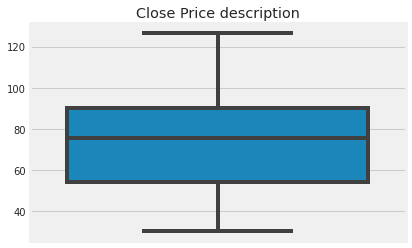

In [27]:
sns.boxplot(y=dataset.iloc[:, 5: 6].values)
plt.title("Close Price description")
plt.show()

Giá cổ phiếu trải dài từ 30,000vnd đến 126,500vnd, tập trung nhiều ở mức 75,000vnd, không có giá trị `null` và không âm; do đó thì sẽ scale các giá trị lại trong khoảng 0, 1 bằng `MinMaxScaler` để cho mô hình dễ học hơn.

In [24]:
dataset_values = dataset.iloc[:, 5: 6].values

In [28]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_dataset = scaler.fit_transform(dataset_values)

Để xác định giá chứng khoán sau mỗi 15 phút thì set giá trị `seq_len=15` 

Chia `train: val: test = 0.7: 0.2: 0.1`

In [29]:
X_train, y_train, X_test, y_test = split_data(scaled_dataset, seq_len=15, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=False, test_size=0.2)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

print(f"X_val.shape: {X_val.shape}")
print(f"y_val.shape: {y_val.shape}")

print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (330709, 15, 1)
y_train.shape: (330709, 1)
X_val.shape: (82678, 15, 1)
y_val.shape: (82678, 1)
X_test.shape: (45933, 15, 1)
y_test.shape: (45933, 1)


In [30]:
train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

val_dataset = TimeSeriesDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = TimeSeriesDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Training và evaluation

Để cho quá trình train dễ theo dõi và đẹp hơn thì em đã viết thêm một số hàm dưới đây, và quan trọng nhất là nó **không ảnh hướng đến hiệu suất của mô hình**.

In [24]:

#@markdown __`utils`__

#@markdown NOTE: Source code in this cell is inspired by YOLOv5 training process.
#@markdown ***

import logging
import os
import platform

LOGGING_NAME = 'Finpros-Technical-Test'
#@markdown `set_logging(name=LOGGING_NAME, verbose=True)`
def set_logging(name=LOGGING_NAME, verbose=True):
    ''' Logging configs, based on YOLOv5 repository.
    '''
    rank = int(os.getenv('RANK', -1))
    level = logging.INFO if verbose and rank in {-1, 0} else logging.ERROR
    logging.config.dictConfig({
        "version": 1,
        "disable_existing_loggers": False,
        "formatters": {
            name: {
                "format": "%(message)s"
            }
        },
        "handlers": {
            name: {
                "class": "logging.StreamHandler",
                "formatter": name,
                "level": level
            }
        },
        "loggers": {
            name: {
                "level": level,
                "handlers": [name],
                "propagate": False
            }
        }
    })

set_logging(LOGGING_NAME)

LOGGER = logging.getLogger(LOGGING_NAME)

#@markdown `colorstr(*input) -> str`
def colorstr(*input) -> str:
    """ String colorization and style

    Args:
        *inputs: these inputs are `color`, `style`, `str` respectively.
            (default: `('blue', 'bold', str)`)

    Return:
        Colored string
    """
    *args, string = input if len(input) > 1 else ('blue', 'bold', input[0])
    colors = {'black': '\033[30m',  # basic colors
              'red': '\033[31m',
              'green': '\033[32m',
              'yellow': '\033[33m',
              'blue': '\033[34m',
              'magenta': '\033[35m',
              'cyan': '\033[36m',
              'white': '\033[37m',
              'bright_black': '\033[90m',  # bright colors
              'bright_red': '\033[91m',
              'bright_green': '\033[92m',
              'bright_yellow': '\033[93m',
              'bright_blue': '\033[94m',
              'bright_magenta': '\033[95m',
              'bright_cyan': '\033[96m',
              'bright_white': '\033[97m',
              'end': '\033[0m',  # misc
              'bold': '\033[1m',
              'underline': '\033[4m'}
    return ''.join(colors[x] for x in args) + f'{string}' + colors['end']

#@markdown `emojis(str='') -> str`
def emojis(str=''):
    # Return platform-dependent emoji-safe version of string
    return str.encode().decode('ascii', 'ignore') if platform.system() == 'Windows' else str

In [25]:
def train(model, dataloaders, criterion, optimizer, num_epochs, device='cuda'):

    LOGGER.info(f"{emojis('✅')} {colorstr('Device:')} {device}")
    LOGGER.info(f"{emojis('✅')} {colorstr('Optimizer:')} {optimizer}")

    LOGGER.info(
        f"\n{emojis('✅')} {colorstr('Loss:')} {type(criterion).__name__}")

    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(num_epochs):
        # Loop over the data for each epoch
        LOGGER.info(colorstr(f'\nEpoch {epoch}/{num_epochs - 1}:'))
        LOGGER.info(colorstr('-' * 10))
        for phase in ['train', 'val']:
            running_loss = 0.0

            if phase == 'train':
                LOGGER.info(colorstr('black', 'bold', '%20s' + '%15s' * 2) % 
                            ('Training:', 'gpu_mem', 'loss'))
                model.train()
            else:
                LOGGER.info(colorstr('black', 'bold', '\n%20s' + '%15s' * 2) % 
                            ('Validation:','gpu_mem', 'loss'))
                model.eval()

            _phase = tqdm(dataloaders[phase],
                      total=len(dataloaders[phase]),
                      bar_format='{desc} {percentage:>7.0f}%|{bar:10}{r_bar}{bar:-10b}',
                      unit='batch')

            for inputs, labels in _phase:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item()

                mem = f'{torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0:.3g}GB'
                desc = ('%35s' + '%15.6g' * 1) % (mem, running_loss)
                _phase.set_description_str(desc)

            history[f'{phase}_loss'].append(running_loss)

    return history

In [26]:
history = train(model, 
                {
                    'train': train_loader,
                    'val': val_loader
                }, 
                criterion, 
                optimizer, 
                num_epochs=50,
                device=device)

✅ Device: cuda
✅ Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

✅ Loss: MSELoss

Epoch 0/49:
----------
           Training:        gpu_mem           loss
                           0.0524GB         57.249     100%|██████████| 2584/2584 [00:15<00:00, 167.05batch/s]

         Validation:        gpu_mem           loss
                           0.0524GB        467.497     100%|██████████| 646/646 [00:03<00:00, 208.65batch/s]

Epoch 1/49:
----------
           Training:        gpu_mem           loss
                           0.0524GB        43.0436     100%|██████████| 2584/2584 [00:16<00:00, 159.16batch/s]

         Validation:        gpu_mem           loss
                           0.0524GB        436.737     100%|██████████| 646/646 [00:03<00:00, 196.07batch/s]

Epoch 2/49:
----------
           Training:        gpu_mem           loss
          

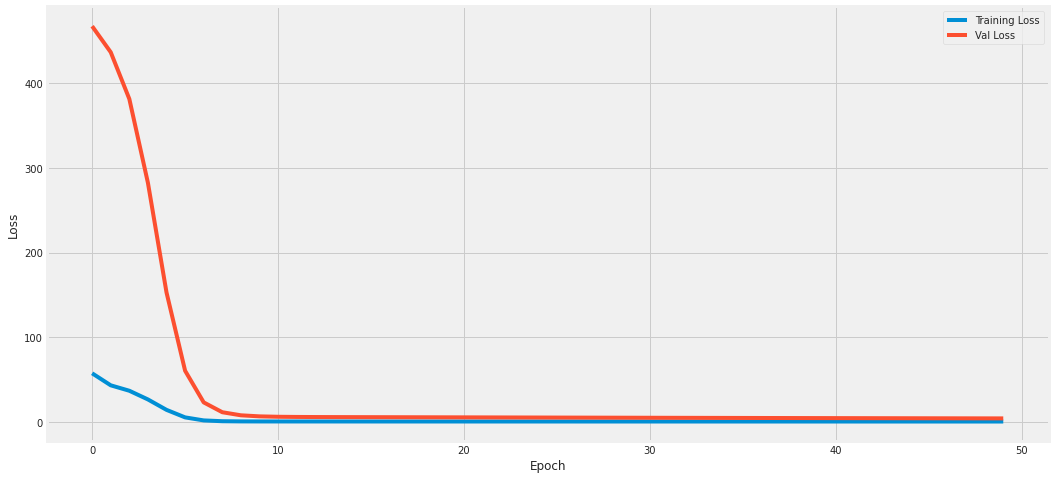

In [36]:
plt.figure(figsize=(16, 8))
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Val Loss'])
plt.savefig("Training Performance.png")
plt.show()

In [37]:
torch.save(model.state_dict(), "./LSTM_weight.pth")

## Test

Để không chạy lại phần train, em xin cung cấp link download trọng số ở phía dưới.

In [41]:
!wget https://github.com/trnhattan/Finpros-Technical-Test/raw/main/weights/LSTM_weight.pth

--2023-02-25 16:30:07--  https://github.com/trnhattan/Finpros-Technical-Test/raw/main/weights/LSTM_weight.pth
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/trnhattan/Finpros-Technical-Test/main/weights/LSTM_weight.pth [following]
--2023-02-25 16:30:07--  https://raw.githubusercontent.com/trnhattan/Finpros-Technical-Test/main/weights/LSTM_weight.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203811 (199K) [application/octet-stream]
Saving to: ‘LSTM_weight.pth’

LSTM_weight.pth     100%[===================>] 199.03K  --.-KB/s    in 0.002s  

2023-02-25 16:30:07 (78.2 MB/s) - ‘LSTM_weigh

In [32]:
def refer(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    preds = np.array([])
    for inputs, labels in tqdm(test_loader, total=len(test_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        with torch.no_grad():
            outputs = model(inputs)
            preds = np.append(preds, outputs.detach().cpu().squeeze().numpy())
            loss = criterion(outputs, labels)

            test_loss += loss.item()

    print(f"\nLoss: {test_loss}")
    print("\n")

    return preds

Load lại trọng số đã lưu

In [42]:
model.load_state_dict(torch.load("./LSTM_weight.pth"))

<All keys matched successfully>

Kết quả của mô hình trong việc dự đoán giá chứng khoán

In [43]:
preds = refer(model, test_loader, criterion)

100%|██████████| 359/359 [00:00<00:00, 474.37it/s]


Loss: 0.017110760811760883




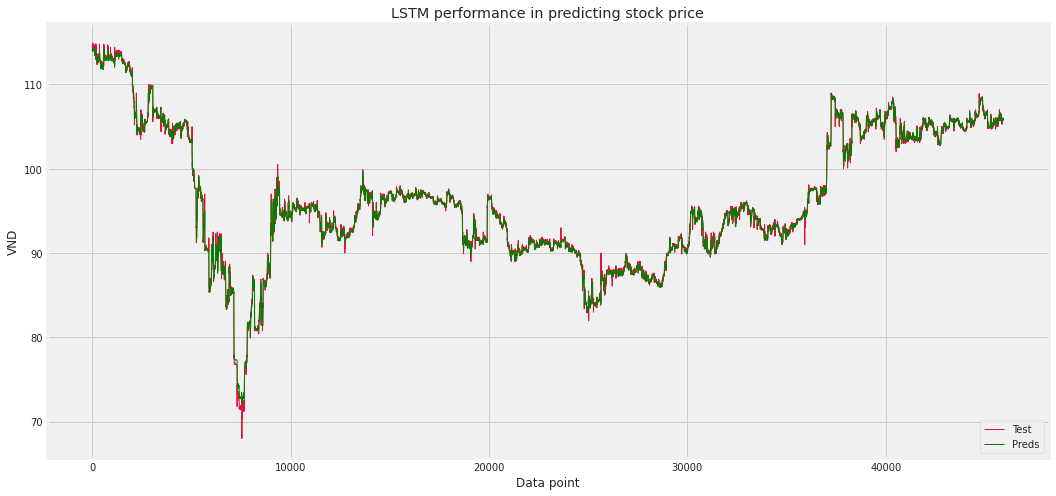

In [44]:
inversed_preds = scaler.inverse_transform(preds.reshape(-1, 1))
inversed_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(16,8))

sns.lineplot(x=range(len(inversed_y_test)), y=inversed_y_test.reshape(-1), color='crimson', linewidth=1)
sns.lineplot(x=range(len(inversed_preds)), y=inversed_preds.reshape(-1), color='g', linewidth=1)

plt.title('LSTM performance in predicting stock price')
plt.xlabel('Data point')
plt.ylabel('VND')


plt.legend(['Test', 'Preds'], loc='lower right')
plt.savefig("./LSTM performance on testset.png")

plt.show()

# Kết quả

Dưới đây là kết quả của bài toán xác định biến động giá

In [ ]:
testset_df = dataset.iloc[len(X_train) + len(X_val) + 15: , :]
testset_df['Date/Time'] = pd.to_datetime(testset_df['Date/Time'])
testset_df['Time'] = [d.time() for d in testset_df['Date/Time']]
testset_df['Date/Time'] = [d.date() for d in testset_df['Date/Time']]
testset_df.rename(columns={"Date/Time": "Date"}, inplace=True)
testset_df['Price_Diff'] = testset_df.groupby(testset_df['Date'])['Close'].diff()

testset_df

In [ ]:
testset_df['Close_Price_Preds'] = inversed_preds
testset_df['Price_Diff_Preds'] = testset_df.groupby(testset_df['Date'])['Close_Price_Preds'].diff()

testset_df.dropna(inplace=True)
testset_df

Loss giữa groundtruth và dự đoán

In [107]:
import torch.nn as nn
criterion = nn.MSELoss()

In [108]:
price_diff = testset_df['Price_Diff'].values
pred_price_diff = testset_df['Price_Diff_Preds'].values

In [109]:
criterion(torch.from_numpy(price_diff),
          torch.from_numpy(pred_price_diff))

tensor(0.0452, dtype=torch.float64)

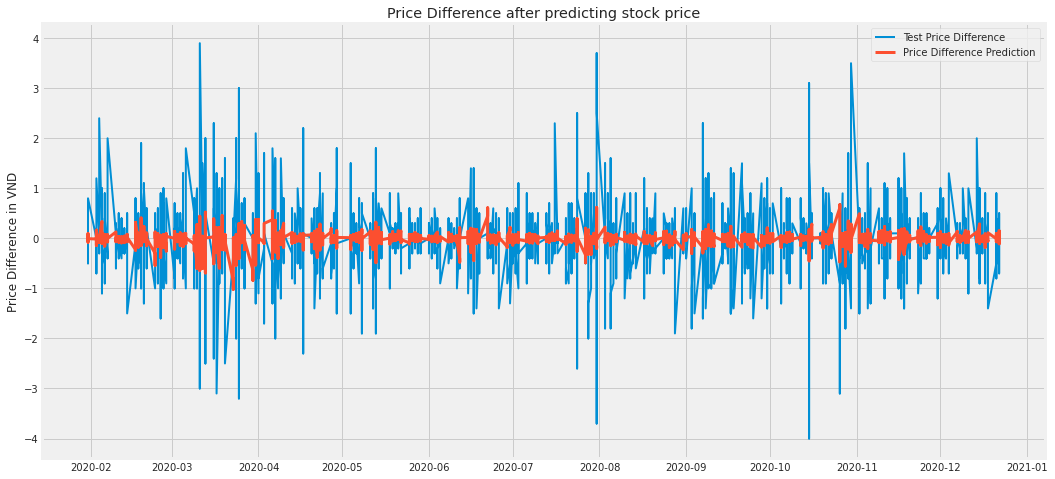

In [111]:
plt.figure(figsize=(16, 8))

plt.plot(testset_df['Date'], testset_df['Price_Diff'], linewidth=2)
plt.plot(testset_df['Date'], testset_df['Price_Diff_Preds'], linewidth=3)

# plt.xticks(testset_df['Date'])

plt.title("Price Difference after predicting stock price")
plt.ylabel('Price Difference in VND')
plt.legend(["Test Price Difference", "Price Difference Prediction"])
# plt.savefig("./Results.png")
plt.show()